In [1]:

import pandas as pd
import matplotlib.pyplot as plt


import os



In [2]:
dataset_file_path = "/home/joao/Documents/repos/renewable-generation-into-reserve-markets/data/DynamicSecondary.csv"

In [3]:
dataset = pd.read_csv(dataset_file_path, index_col=0)

In [4]:
dataset['Day'] = (dataset.index + 24) // 24

In [5]:
dataset = dataset.groupby("Day").sum()

In [6]:
# Simply remove NAN 
dataset = dataset.dropna(how='any')



/home/joao/.virtualenvs/tese/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


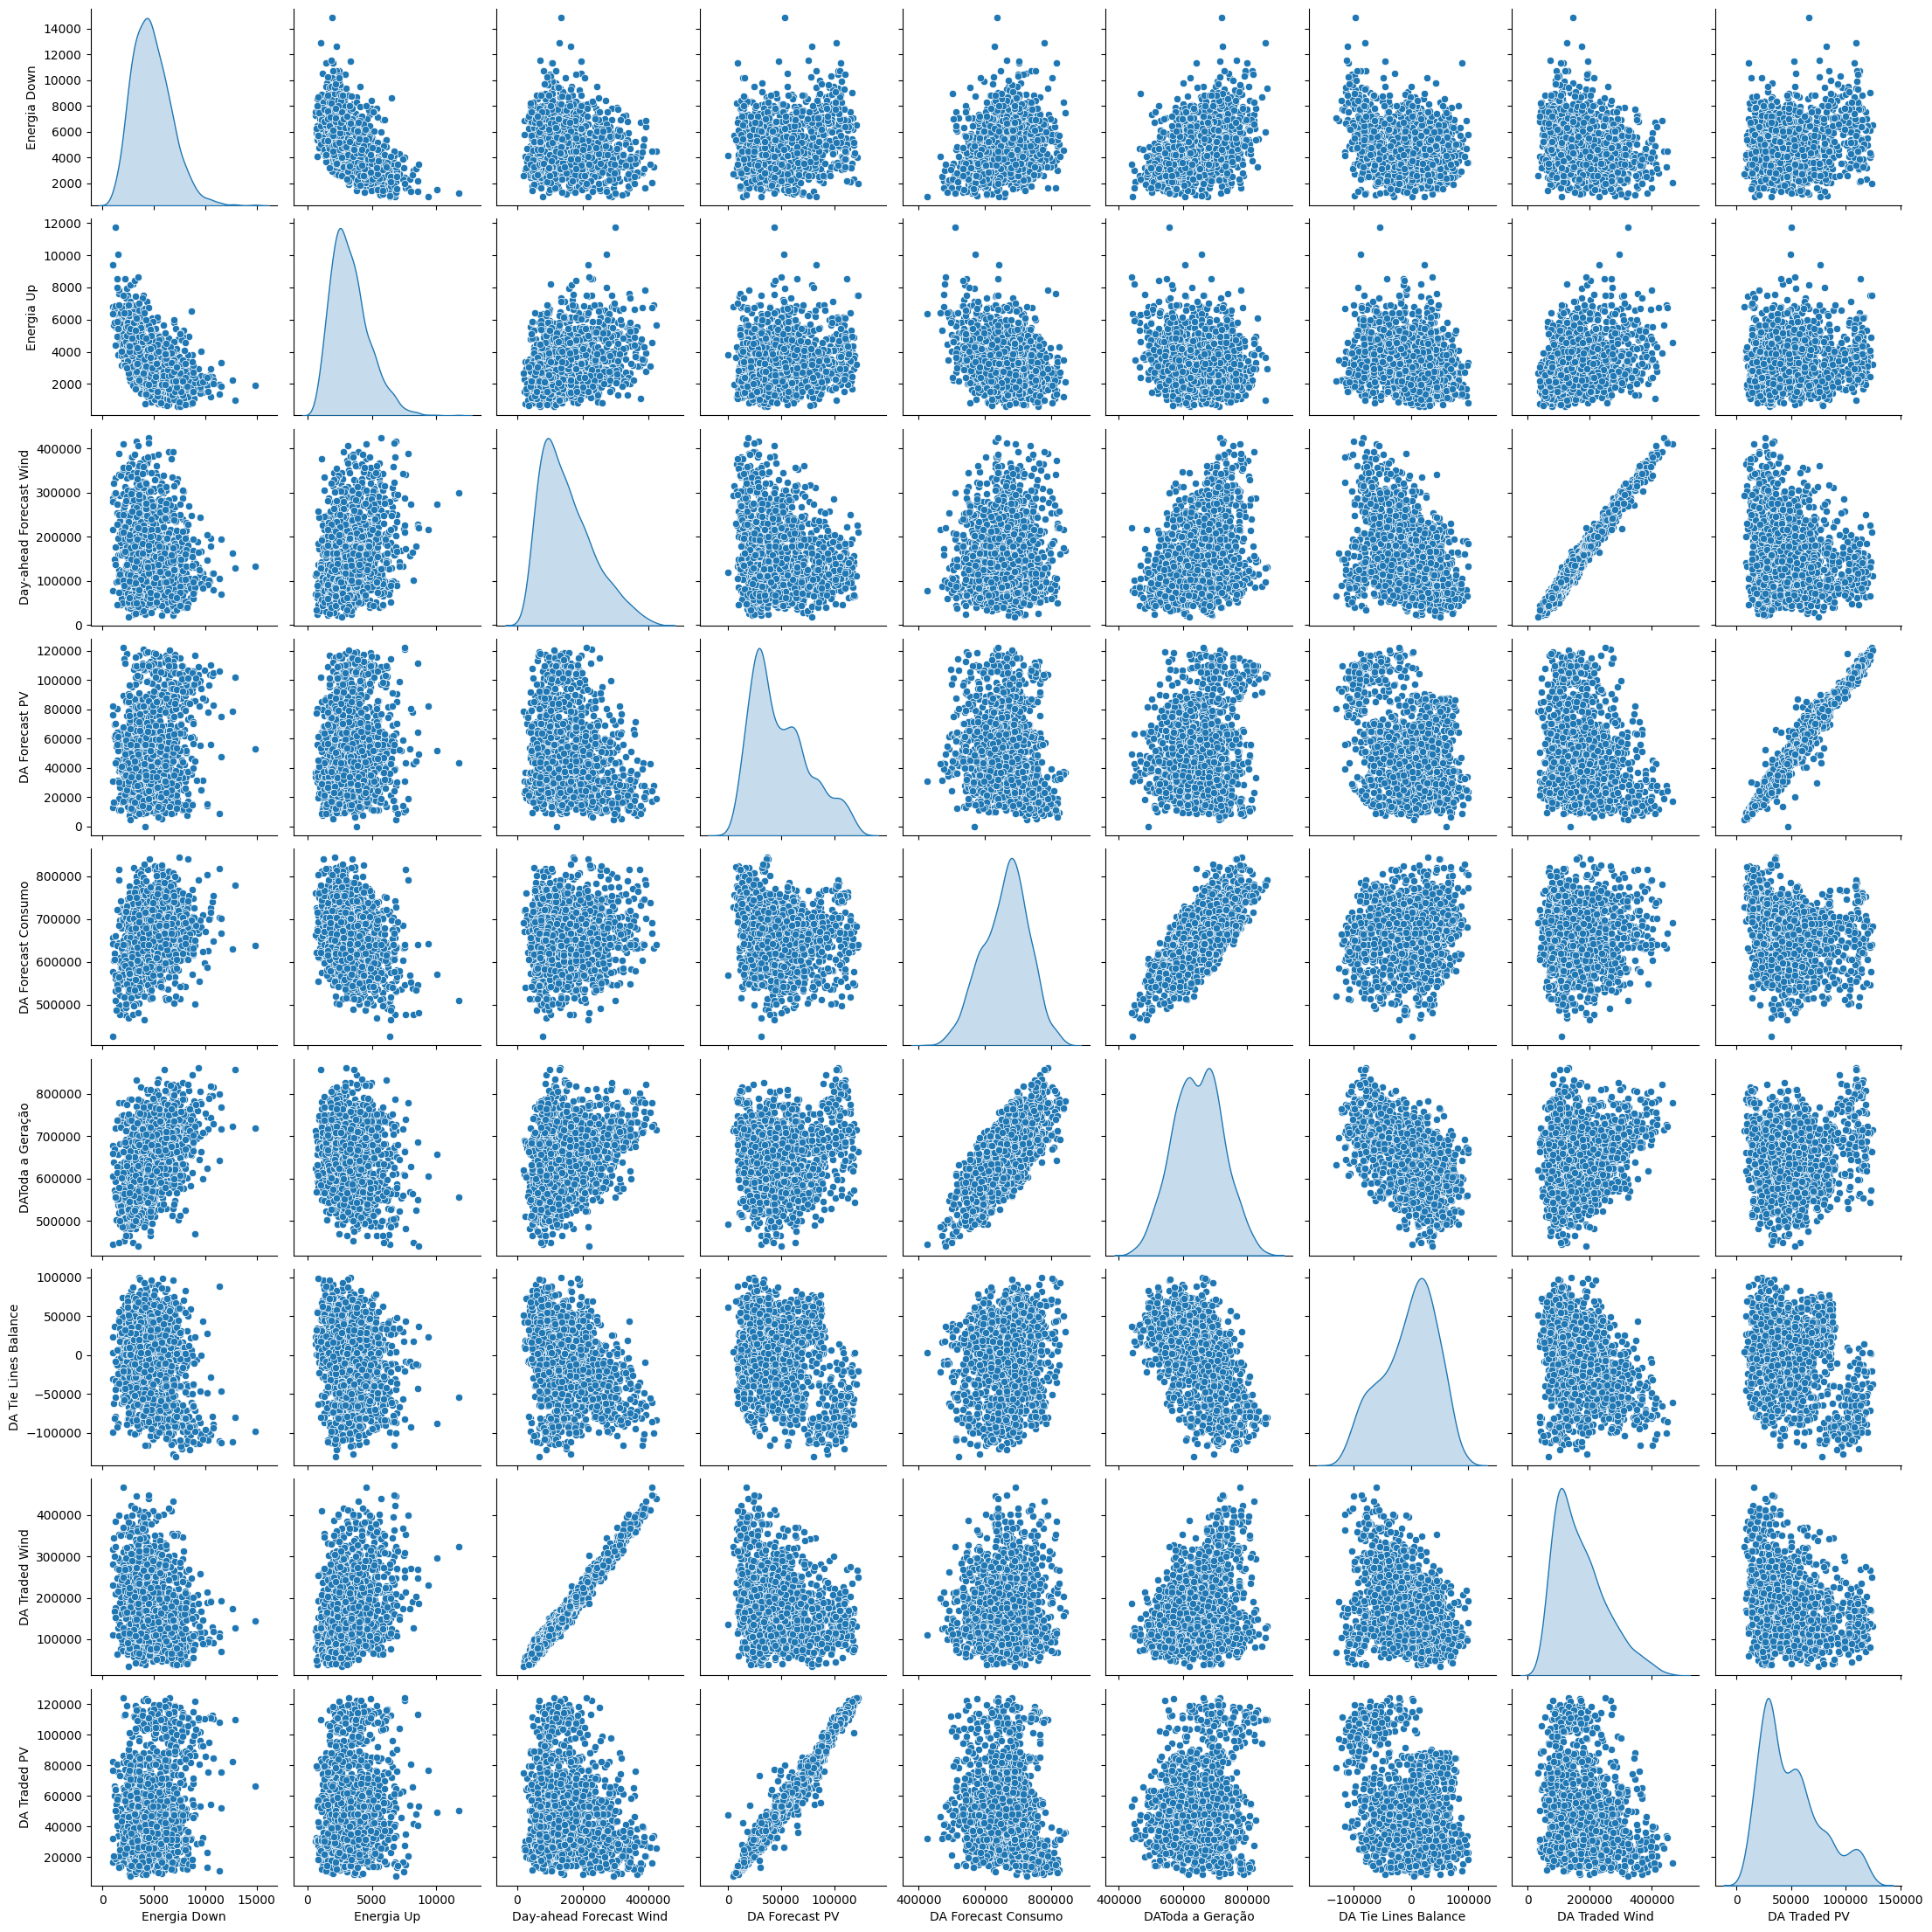

In [7]:
import seaborn as sns

columns_Y = ["Energia Down", "Energia Up"]
columns_X = dataset.columns[~dataset.columns.isin(columns_Y)] 
sns.pairplot(dataset, diag_kind='kde')


In [8]:
dataset.describe().transpose()


count           mean           std       min  \
Energia Down             1461.0    4793.417248   1883.235378     973.6   
Energia Up               1461.0    3297.301300   1478.949237     601.7   
Day-ahead Forecast Wind  1461.0  152972.649350  80567.184556   19635.0   
DA Forecast PV           1461.0   49222.586567  27262.066163       0.0   
DA Forecast Consumo      1461.0  662475.331417  69531.913589  425413.0   
DAToda a Geração         1461.0  647057.712047  76263.262358  439263.1   
DA Tie Lines Balance     1461.0   -3649.662012  47811.286579 -130516.6   
DA Traded Wind           1461.0  170185.323066  82507.207507   33931.5   
DA Traded PV             1461.0   50026.923682  27529.210115    7362.2   

                              25%       50%       75%        max  
Energia Down               3399.0    4581.5    5958.7   14865.10  
Energia Up                 2215.5    3078.0    4096.8   11715.00  
Day-ahead Forecast Wind   89929.0  136621.0  201301.9  424538.20  
DA Forecast PV            28047.2   43310.3   65831.5  122149.45  
DA Forecast Consumo      615606.0  669419.0  710559.0  842990.00  
DAToda a Geração         592389.0  647714.5  700761.7  862044.90  
DA Tie Lines Balance     -37592.0    3170.5   32138.8   99515.30  
DA Traded Wind           106386.5  152889.0  217472.8  466246.70  
DA Traded PV              28779.1   43808.1   65527.8  124267.70

In [9]:
## Queremos prever as colunas "Energia Down" e "Energia Up" 
## Logo temos de criar um gerador que de os dados


# Create a generator for the timeseries with a moving window.

from tensorflow import keras
import math

#1461 -> 1 day

one_day = 1461

class DataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        dataset,
        time_moving_window_size_X=7, #batch size 7 days, 168 hours,
        time_moving_window_size_Y=1, #to predict the after 1 day, 24 hours,
        y_columns = ["Energia Down", "Energia Up"],
        keep_y_on_x=False,
    ):
        self.y_columns = y_columns
        self.y = dataset[self.y_columns].to_numpy()
        if not keep_y_on_x:
            self.x = dataset.loc[:, ~dataset.columns.isin(self.y_columns)].to_numpy()
        else:
            self.x = dataset.to_numpy()
            
        self.x_batch = time_moving_window_size_X
        self.y_batch = time_moving_window_size_Y
        
        self.dataset_size = len(dataset)
        
    def __len__(self):
        # The return value is the actual generator size, the number of times it
        # can be called.
        
        return self.dataset_size - sum([self.x_batch,self.y_batch])

    def __getitem__(self, index):
        
        limit_point = index+self.x_batch
        
        X = self.x[index:limit_point]
        Y = self.y[limit_point:limit_point+self.y_batch]
        
        return X, Y, index

        


2023-07-19 18:06:35.452310: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-19 18:06:35.453548: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-19 18:06:35.478873: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-19 18:06:35.479553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 18:06:35.994370: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [10]:
import numpy as np
import math




def get_dataset(dataset,  time_moving_window_size_X=168, #batch size 7 days, 168 hours,
        time_moving_window_size_Y=24, #to predict the after 1 day, 24 hours,
        y_columns = ["Energia Down", "Energia Up"],
        keep_y_on_x=False,
                frac=0.8,
                
):
    gen = DataGenerator(dataset, time_moving_window_size_X, time_moving_window_size_Y, y_columns, keep_y_on_x)


    X, Y, ind = [], [], []

    for x, y,i in gen:
        X.append(x)
        Y.append(y)
        ind.append(i)
    X = np.array(X)
    Y = np.array(Y)


    train_len = math.ceil(frac * len(X))
    test_len = len(X) - train_len

    
    
    train_dataset_X = X[:train_len]
    test_dataset_X = X[train_len:train_len+test_len]


    train_dataset_Y = Y[:train_len]
    test_dataset_Y = Y[train_len:train_len+test_len]
    
    test_index = ind[train_len:train_len+test_len]
    
    
    return train_dataset_X, train_dataset_Y, test_dataset_X, test_dataset_Y, np.array(test_index)

In [11]:
test_dataset = dataset.copy()

In [12]:
X_timeseries = 1
Y_timeseries = 1

train_dataset_X, train_dataset_Y, test_dataset_X, test_dataset_Y,test_index = get_dataset(dataset, 
                                                                               time_moving_window_size_X=X_timeseries,
                                                                              time_moving_window_size_Y=Y_timeseries,
                                                                              )

In [13]:

end_ind = test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[-1][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[-1][0][1])].index.item()
start_ind = test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[0][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[0][0][1])].index.item()

In [14]:
test_dataset.loc[start_ind:end_ind]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
Day                                                                       
1170        4671.5      2603.8                 303941.0       28886.200   
1171        8326.4      1855.2                 229083.0       17359.200   
1172        2557.3      4386.5                 356808.0       31032.700   
1173        4713.2      3337.6                 193511.0       46926.600   
1174        2181.5      3172.3                 167754.0       49677.300   
...            ...         ...                      ...             ...   
1456        7520.9      5099.3                  44488.4       51725.550   
1457        7228.5      3053.5                  62953.8       53616.075   
1458        4616.6      4176.3                 201301.9       52068.150   
1459        6075.9      5159.1                 262304.4       30793.750   
1460        4192.2      4867.0                 321437.3       35352.575   

      DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
Day                                                                 
1170             678263.0          770864.4             -103784.8   
1171             677987.0          709206.9              -40063.8   
1172             680186.0          752746.6              -82460.1   
1173             675238.0          654542.1                7413.8   
1174             590841.0          554985.7               32538.8   
...                   ...               ...                   ...   
1456             541846.9          513375.4               -4796.4   
1457             584216.1          566693.5                2401.5   
1458             588861.7          594076.6              -18313.3   
1459             596548.0          577704.6              -10737.5   
1460             584977.7          576596.5              -12904.7   

      DA Traded Wind  DA Traded PV  
Day                                 
1170        312946.6       43617.2  
1171        232257.9       36909.5  
1172        382493.2       46340.1  
1173        210099.4       56685.0  
1174        162813.5       56635.3  
...              ...           ...  
1456         66739.8       57127.0  
1457         77798.2       62140.5  
1458        223593.1       59960.3  
1459        279898.9       42265.3  
1460        314735.0       37485.8  

[291 rows x 9 columns]

In [15]:
train_dataset_X.shape

(1168, 1, 7)

In [16]:
from tensorflow.keras import backend as K


def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import (
    Normalization,
    Dense,Dropout

)
from keras.models import Model

input_layer = Input((7))
normed = Normalization()(input_layer)
output = Dense(2, activation="linear")(normed)

model_dense = Model(inputs=input_layer, outputs=output)


In [18]:
model_dense.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization (Normalizati  (None, 7)                 15        
 on)                                                             
                                                                 
 dense (Dense)               (None, 2)                 16        
                                                                 
Total params: 31 (128.00 Byte)
Trainable params: 16 (64.00 Byte)
Non-trainable params: 15 (64.00 Byte)
_________________________________________________________________


In [19]:
model_dense.compile(optimizer='adam',loss=root_mean_squared_error, metrics=root_mean_squared_error)

In [20]:
model_dense.fit(train_dataset_X.squeeze(), train_dataset_Y.squeeze(), epochs=30)

Epoch 1/30
37/37 [==============================] - 0s 1ms/step - loss: 505989.0000 - root_mean_squared_error: 505453.6875
Epoch 2/30
37/37 [==============================] - 0s 1ms/step - loss: 449164.8125 - root_mean_squared_error: 448835.2812
Epoch 3/30
37/37 [==============================] - 0s 954us/step - loss: 394891.9375 - root_mean_squared_error: 394511.6875
Epoch 4/30
37/37 [==============================] - 0s 903us/step - loss: 343248.4688 - root_mean_squared_error: 342941.9062
Epoch 5/30
37/37 [==============================] - 0s 972us/step - loss: 294416.3438 - root_mean_squared_error: 293984.5938
Epoch 6/30
37/37 [==============================] - 0s 1ms/step - loss: 247823.4531 - root_mean_squared_error: 247257.9531
Epoch 7/30
37/37 [==============================] - 0s 986us/step - loss: 203003.4531 - root_mean_squared_error: 202877.5156
Epoch 8/30
37/37 [==============================] - 0s 912us/step - loss: 159592.4844 - root_mean_squared_error: 159311.1562
Epoch 

In [21]:
predictions = model_dense.predict(test_dataset_X.squeeze())

10/10 [==============================] - 0s 1ms/step


In [22]:
model_dense.history

In [23]:
model_dense.evaluate(test_dataset_X.squeeze(), test_dataset_Y.squeeze())

10/10 [==============================] - 0s 1ms/step - loss: 28649.0703 - root_mean_squared_error: 27740.4375


[28649.0703125, 27740.4375]

In [24]:
len(predictions)

291

In [25]:
len(test_dataset_Y)

291

In [26]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
Day                                                                       
1           3208.1      3884.2                  83498.0       18200.400   
2           4229.3      2959.8                 192063.0       17533.200   
3           4145.4      1638.5                 104731.0       16052.500   
4           6426.2      1909.4                  76990.0       17527.500   
5           4404.1      3164.6                 126802.0       18725.900   
...            ...         ...                      ...             ...   
1457        7228.5      3053.5                  62953.8       53616.075   
1458        4616.6      4176.3                 201301.9       52068.150   
1459        6075.9      5159.1                 262304.4       30793.750   
1460        4192.2      4867.0                 321437.3       35352.575   
1461        3484.7      8618.4                 220095.8       49667.725   

      DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
Day                                                                 
1                551279.0          482204.4               51667.1   
2                717903.0          608859.8               56969.3   
3                770761.0          638226.1               52212.9   
4                752428.0          682271.6               21331.5   
5                671707.0          596638.5               35874.6   
...                   ...               ...                   ...   
1457             584216.1          566693.5                2401.5   
1458             588861.7          594076.6              -18313.3   
1459             596548.0          577704.6              -10737.5   
1460             584977.7          576596.5              -12904.7   
1461             481006.5          439263.1               37075.8   

      DA Traded Wind  DA Traded PV  
Day                                 
1            97837.6       19967.0  
2           201687.1       18444.8  
3           112056.9       16760.5  
4            82172.4       17801.4  
5           145371.3       18896.8  
...              ...           ...  
1457         77798.2       62140.5  
1458        223593.1       59960.3  
1459        279898.9       42265.3  
1460        314735.0       37485.8  
1461        187213.9       53107.4  

[1461 rows x 9 columns]

In [27]:
test_dataset["dense Energia Down"] = None
test_dataset["dense Energia Up"] = None

test_dataset.loc[start_ind:end_ind, "dense Energia Down"] = predictions[:,0]
test_dataset.loc[start_ind:end_ind, "dense Energia Up"] = predictions[:,1]


In [28]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
Day                                                                       
1           3208.1      3884.2                  83498.0       18200.400   
2           4229.3      2959.8                 192063.0       17533.200   
3           4145.4      1638.5                 104731.0       16052.500   
4           6426.2      1909.4                  76990.0       17527.500   
5           4404.1      3164.6                 126802.0       18725.900   
...            ...         ...                      ...             ...   
1457        7228.5      3053.5                  62953.8       53616.075   
1458        4616.6      4176.3                 201301.9       52068.150   
1459        6075.9      5159.1                 262304.4       30793.750   
1460        4192.2      4867.0                 321437.3       35352.575   
1461        3484.7      8618.4                 220095.8       49667.725   

      DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
Day                                                                 
1                551279.0          482204.4               51667.1   
2                717903.0          608859.8               56969.3   
3                770761.0          638226.1               52212.9   
4                752428.0          682271.6               21331.5   
5                671707.0          596638.5               35874.6   
...                   ...               ...                   ...   
1457             584216.1          566693.5                2401.5   
1458             588861.7          594076.6              -18313.3   
1459             596548.0          577704.6              -10737.5   
1460             584977.7          576596.5              -12904.7   
1461             481006.5          439263.1               37075.8   

      DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  
Day                                                                     
1            97837.6       19967.0               None             None  
2           201687.1       18444.8               None             None  
3           112056.9       16760.5               None             None  
4            82172.4       17801.4               None             None  
5           145371.3       18896.8               None             None  
...              ...           ...                ...              ...  
1457         77798.2       62140.5       -5749.852051     11038.884766  
1458        223593.1       59960.3        3529.900391      5128.436523  
1459        279898.9       42265.3        5314.766113    -29489.410156  
1460        314735.0       37485.8        3018.013428    -24735.019531  
1461        187213.9       53107.4               None             None  

[1461 rows x 11 columns]

In [29]:

end_ind = test_dataset[(test_dataset["Day-ahead Forecast Wind"]==test_dataset_X[-1][0][0])&(test_dataset["DA Tie Lines Balance"]==test_dataset_X[-1][0][4])].index.item()
start_ind = test_dataset[(test_dataset["Day-ahead Forecast Wind"]==test_dataset_X[0][0][0])&(test_dataset["DA Tie Lines Balance"]==test_dataset_X[0][0][4])].index.item()

In [30]:
end_ind

1459

In [31]:
test_dataset[start_ind:end_ind+3]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
Day                                                                       
1170        4671.5      2603.8                 303941.0       28886.200   
1171        8326.4      1855.2                 229083.0       17359.200   
1172        2557.3      4386.5                 356808.0       31032.700   
1173        4713.2      3337.6                 193511.0       46926.600   
1174        2181.5      3172.3                 167754.0       49677.300   
...            ...         ...                      ...             ...   
1457        7228.5      3053.5                  62953.8       53616.075   
1458        4616.6      4176.3                 201301.9       52068.150   
1459        6075.9      5159.1                 262304.4       30793.750   
1460        4192.2      4867.0                 321437.3       35352.575   
1461        3484.7      8618.4                 220095.8       49667.725   

      DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
Day                                                                 
1170             678263.0          770864.4             -103784.8   
1171             677987.0          709206.9              -40063.8   
1172             680186.0          752746.6              -82460.1   
1173             675238.0          654542.1                7413.8   
1174             590841.0          554985.7               32538.8   
...                   ...               ...                   ...   
1457             584216.1          566693.5                2401.5   
1458             588861.7          594076.6              -18313.3   
1459             596548.0          577704.6              -10737.5   
1460             584977.7          576596.5              -12904.7   
1461             481006.5          439263.1               37075.8   

      DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  
Day                                                                     
1170        312946.6       43617.2        3300.335938     17784.695312  
1171        232257.9       36909.5        3817.607422     32610.136719  
1172        382493.2       46340.1        7750.302246     34513.023438  
1173        210099.4       56685.0        3051.034912      -6986.47168  
1174        162813.5       56635.3        9187.203125    -19042.279297  
...              ...           ...                ...              ...  
1457         77798.2       62140.5       -5749.852051     11038.884766  
1458        223593.1       59960.3        3529.900391      5128.436523  
1459        279898.9       42265.3        5314.766113    -29489.410156  
1460        314735.0       37485.8        3018.013428    -24735.019531  
1461        187213.9       53107.4               None             None  

[292 rows x 11 columns]

In [32]:
import h5py
uri = "model_dense_day.keras"
model_dense.save(uri)


In [33]:
def plot_pred_vs_test(test_x, test_y,pred_y):
    # Plot data for dimension 1
    plt.subplot(2, 1, 1)
    print(test_x.shape)
    print(test_y.shape)

    plt.scatter(test_x, test_y[:, 0], label='Energia Down Data')
    plt.plot(test_x, pred_y[:, 0], color='k', label='Energia Down Predictions')
    plt.xlabel('Test X')
    plt.ylabel('Energia Down')
    plt.title('Energia Down: Predictions vs. Test Data')
    plt.legend()

    # Plot data for dimension 2
    plt.subplot(2, 1, 2)
    plt.scatter(test_x, test_y[:, 1], label='Energia Up Data')
    plt.plot(test_x, pred_y[:, 1], color='k', label='Energia Up Predictions')
    plt.xlabel('Test X')
    plt.ylabel('Energia Up')
    plt.title('Energia Up: Predictions vs. Test Data')
    plt.legend()

    plt.tight_layout()
    plt.show()


(291,)
(291, 2)


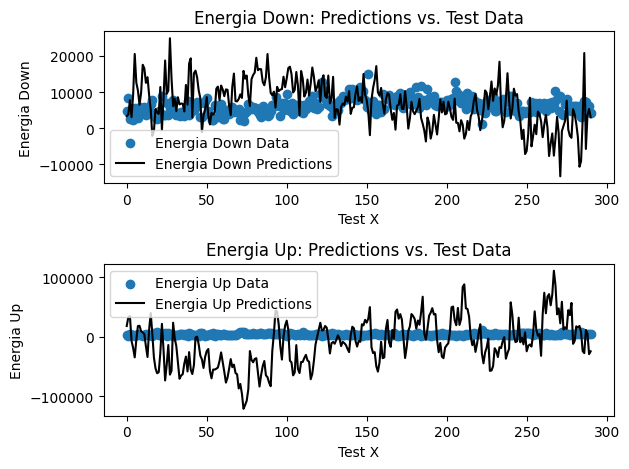

In [34]:
plot_pred_vs_test(np.arange(len(test_dataset_X)), test_dataset_Y.squeeze(), predictions)

In [35]:
def plot_percentage_diffs(predictions, test_dataset_Y):
    mse_dim1 = np.mean((predictions[:, 0] - test_dataset_Y.squeeze()[:,0]) ** 2)
    rmse_dim1 = np.sqrt(mse_dim1)

    mse_dim2 = np.mean((predictions[:, 1] - test_dataset_Y.squeeze()[:,1]) ** 2)
    rmse_dim2 = np.sqrt(mse_dim2)

    mse = np.mean((predictions - test_dataset_Y.squeeze()) ** 2)
    rmse = np.sqrt(mse)

    
    print("The root mean squared erros in Energia down is",rmse_dim1)
    print("The root mean squared erros in Energia up is",rmse_dim2)
    
    print("The root mean squared erros in both is",rmse)
    
    
    differences_dim1_percentage = ((predictions[:, 0]+1.62) - (test_dataset_Y.squeeze()[:,0]+1.62))/test_dataset_Y.squeeze()[:, 0]+1.62
    differences_dim2_percentage = ((predictions[:, 1]+1.62) - (test_dataset_Y.squeeze()[:,0]+1.62))/test_dataset_Y.squeeze()[:, 1]+1.62

    differences_percentage = ((predictions+1.62) - (test_dataset_Y.squeeze()+1.62))/(predictions+1.62)

    plt.figure(figsize=(10, 6))

    # Plot differences for dimension 1
    plt.subplot(3, 1, 1)
    plt.plot(range(len(differences_dim1_percentage)), differences_dim1_percentage, 'b.')
    plt.xlabel('Row Index')
    plt.ylabel('Difference')
    plt.title('Energia down: Individual Differences percentage')

    # Plot differences for dimension 2
    plt.subplot(3, 1, 2)
    plt.plot(range(len(differences_dim2_percentage)), differences_dim2_percentage, 'g.')
    plt.xlabel('Row Index')
    plt.ylabel('Difference')
    plt.title('Energia up: Individual Differences percentage')
    
    plt.subplot(3, 1, 3)
    plt.plot(range(len(differences_percentage)), differences_percentage, 'g.')
    plt.xlabel('Row Index')
    plt.ylabel('Difference')
    plt.title('Both: Individual Differences percentage')

    plt.tight_layout()
    plt.show()

The root mean squared erros in Energia down is 6707.288211903117
The root mean squared erros in Energia up is 42060.19425083087
The root mean squared erros in both is 30116.836284503395


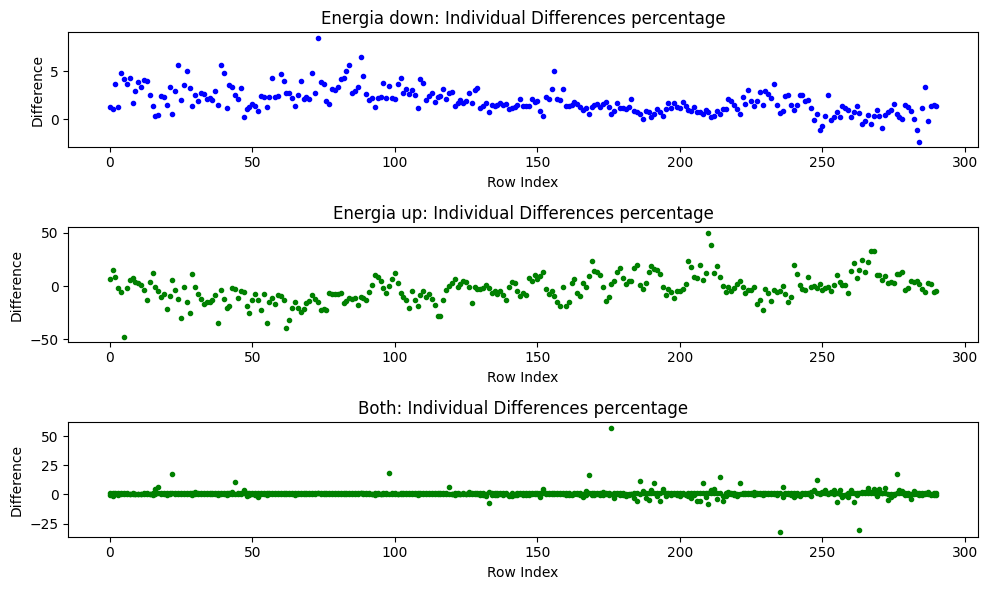

In [36]:
plot_percentage_diffs(predictions, test_dataset_Y)

In [37]:
# Multiple dense layers



input_layer = Input((7,))
normed = Normalization()(input_layer)
normed = Dense(168, activation="linear")(normed)
dropped1 = Dropout(0.5)(normed)

normed = Dense(64, activation="linear")(dropped1)
dropped1 = Dropout(0.5)(normed)

output = Dense(2, activation="linear")(dropped1)

model_dense2 = Model(inputs=input_layer, outputs=output)


In [38]:
model_dense2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization_1 (Normaliza  (None, 7)                 15        
 tion)                                                           
                                                                 
 dense_1 (Dense)             (None, 168)               1344      
                                                                 
 dropout (Dropout)           (None, 168)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                10816     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                           

In [39]:
model_dense2.compile(optimizer='adam',loss=root_mean_squared_error, metrics=root_mean_squared_error)
model_dense2.fit(train_dataset_X.squeeze(), train_dataset_Y.squeeze(), epochs=17)

Epoch 1/17
37/37 [==============================] - 1s 1ms/step - loss: 230343.2812 - root_mean_squared_error: 229598.7500
Epoch 2/17
37/37 [==============================] - 0s 1ms/step - loss: 134445.4375 - root_mean_squared_error: 134000.8750
Epoch 3/17
37/37 [==============================] - 0s 1ms/step - loss: 91589.9688 - root_mean_squared_error: 91367.2188
Epoch 4/17
37/37 [==============================] - 0s 2ms/step - loss: 60820.5898 - root_mean_squared_error: 60670.7305
Epoch 5/17
37/37 [==============================] - 0s 2ms/step - loss: 40663.5312 - root_mean_squared_error: 40578.3867
Epoch 6/17
37/37 [==============================] - 0s 2ms/step - loss: 27991.2148 - root_mean_squared_error: 27932.9434
Epoch 7/17
37/37 [==============================] - 0s 2ms/step - loss: 19249.0840 - root_mean_squared_error: 19226.9863
Epoch 8/17
37/37 [==============================] - 0s 2ms/step - loss: 14714.9365 - root_mean_squared_error: 14708.2197
Epoch 9/17
37/37 [==========

In [40]:
predictions = model_dense2.predict(test_dataset_X.squeeze())

10/10 [==============================] - 0s 1ms/step


In [41]:
model_dense2.evaluate(test_dataset_X.squeeze(), test_dataset_Y.squeeze())

10/10 [==============================] - 0s 970us/step - loss: 2966.4412 - root_mean_squared_error: 2897.3259


[2966.441162109375, 2897.325927734375]

In [42]:
test_dataset["dense2 Energia Down"] = None
test_dataset["dense2 Energia Up"] = None

test_dataset.loc[test_index+X_timeseries, "dense2 Energia Down"] = predictions[:,0]
test_dataset.loc[test_index+X_timeseries, "dense2 Energia Up"] = predictions[:,1]


(291,)
(291, 2)


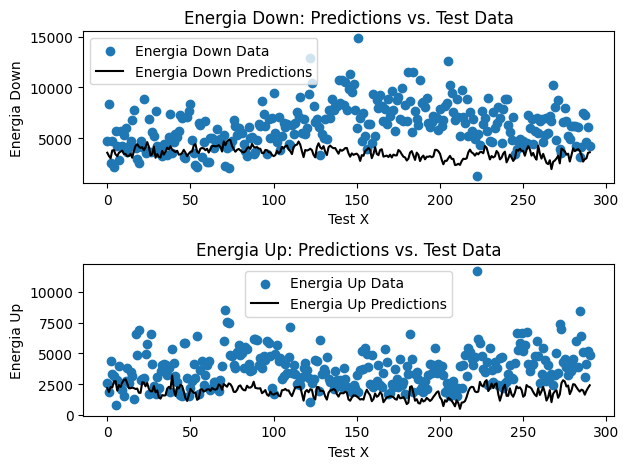

In [43]:
plot_pred_vs_test(np.arange(len(test_dataset_X)), test_dataset_Y.squeeze(), predictions)

The root mean squared erros in Energia down is 3554.67198097314
The root mean squared erros in Energia up is 2414.2137682635966
The root mean squared erros in both is 3038.4305991077877


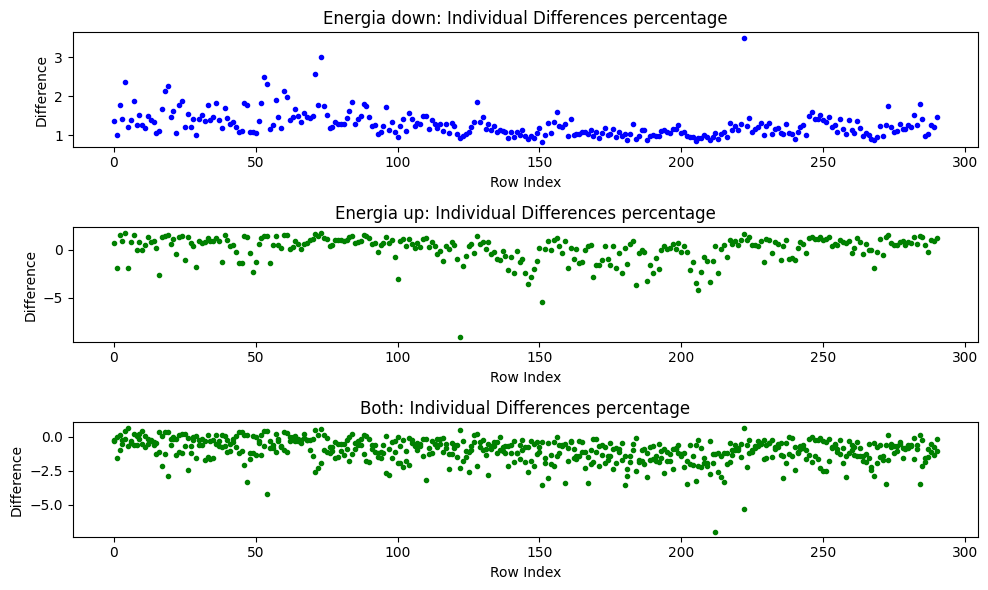

In [44]:
plot_percentage_diffs(predictions, test_dataset_Y)

In [45]:
uri = "model_dense2_day.keras"
model_dense2.save(uri)


In [46]:
test_dataset[test_dataset["dense2 Energia Down"]==test_dataset["dense2 Energia Down"]]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
Day                                                                       
1169        6775.3      1306.9                 335886.0       21657.600   
1170        4671.5      2603.8                 303941.0       28886.200   
1171        8326.4      1855.2                 229083.0       17359.200   
1172        2557.3      4386.5                 356808.0       31032.700   
1173        4713.2      3337.6                 193511.0       46926.600   
...            ...         ...                      ...             ...   
1455        4080.0      6433.5                 216362.6       43157.625   
1456        7520.9      5099.3                  44488.4       51725.550   
1457        7228.5      3053.5                  62953.8       53616.075   
1458        4616.6      4176.3                 201301.9       52068.150   
1459        6075.9      5159.1                 262304.4       30793.750   

      DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
Day                                                                 
1169             670117.0          749540.7              -87289.5   
1170             678263.0          770864.4             -103784.8   
1171             677987.0          709206.9              -40063.8   
1172             680186.0          752746.6              -82460.1   
1173             675238.0          654542.1                7413.8   
...                   ...               ...                   ...   
1455             463612.7          485268.0              -21813.6   
1456             541846.9          513375.4               -4796.4   
1457             584216.1          566693.5                2401.5   
1458             588861.7          594076.6              -18313.3   
1459             596548.0          577704.6              -10737.5   

      DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
Day                                                                      
1169        355977.5       30426.5               None             None   
1170        312946.6       43617.2        3300.335938     17784.695312   
1171        232257.9       36909.5        3817.607422     32610.136719   
1172        382493.2       46340.1        7750.302246     34513.023438   
1173        210099.4       56685.0        3051.034912      -6986.47168   
...              ...           ...                ...              ...   
1455        199697.6       46530.6        2351.299805    -24370.404297   
1456         66739.8       57127.0       20779.195312         -27764.5   
1457         77798.2       62140.5       -5749.852051     11038.884766   
1458        223593.1       59960.3        3529.900391      5128.436523   
1459        279898.9       42265.3        5314.766113    -29489.410156   

     dense2 Energia Down dense2 Energia Up  
Day                                         
1169         3543.971924       2169.174561  
1170         3224.057129       1861.789917  
1171         2991.280762       2260.713135  
1172         3775.865723       2230.301514  
1173         3798.605225         2721.8479  
...                  ...               ...  
1455         2668.876709       1986.699585  
1456         2907.966797       1641.920288  
1457         2984.287598       1963.096924  
1458         3539.932617        2203.24585  
1459         3589.358643       2408.167236  

[291 rows x 13 columns]

In [47]:
35064/24 # this is the number of days in the dataset

1461.0

In [48]:
7*24

168

In [49]:
len(dataset)

1461

In [50]:
# One week to get one day

X_timeseries = 7
Y_timeseries = 1

train_dataset_X, train_dataset_Y, test_dataset_X, test_dataset_Y, index_test = get_dataset(dataset, 
                                                                               time_moving_window_size_X=X_timeseries,
                                                                              time_moving_window_size_Y=Y_timeseries,
                                                                              )

In [51]:

end_ind = test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[-1][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[-1][0][1])].index.item()
start_ind = test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[0][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[0][0][1])].index.item()

In [52]:
## Simple timeries conv model



import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import (
    BatchNormalization,
    Normalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling1D,
    concatenate,
)


from keras.models import Model

time_length = X_timeseries #hours

# channels last -> channels sao as dimensoes diff
input_layer_saphe = (time_length, 7)
filters = 128
dropout_value = 0.25
kernel_size = 3
input_layer = Input(input_layer_saphe)
normed = BatchNormalization()(input_layer)





# first feature extractor
conv1 = Conv1D(
    filters=64,
    kernel_size=kernel_size,
    activation="linear",
)(normed)

normed1 = BatchNormalization()(conv1)
dropped1 = Dropout(dropout_value)(normed1)
convd1 = Conv1D(
    filters=filters,
    kernel_size=kernel_size,
    activation="linear",
)(dropped1)
normed11 = BatchNormalization()(convd1)
pool1 = MaxPooling1D(pool_size=2)(normed11)
# flat1 = Flatten()(pool1)

min_value_inshape = min([f for f in normed.shape if f is not None])
values_consider = []

for i in range(min_value_inshape):
    step = min_value_inshape - i + 1
    if step >= i:
        values_consider.append(i)

kernel_size_second = max(values_consider)

# second feature extractor
conv2 = Conv1D(
    filters=filters,
    kernel_size=kernel_size_second,
    activation='linear',
)(normed)
normed2 = BatchNormalization()(conv2)

dropped2 = Dropout(dropout_value)(normed2)
convd2 = Conv1D(
    filters=filters,
    kernel_size=kernel_size_second,
    activation="linear",
)(dropped2)
normed22 = BatchNormalization()(convd2)
pool_zi = min([f for f in normed22.shape if f is not None])
pool_zi = min([pool_zi, 2])
pool2 = MaxPooling1D(pool_size=pool_zi)(normed22)
# flat2 = Flatten()(pool2)
# merge feature extractors
merge = concatenate([pool1, pool2])
dropped = Dropout(dropout_value)(merge)

# interpretation layer
hidden1 = Dense(100, activation='linear')(dropped)
normed3 = Normalization()(hidden1)
# prediction output
# Reshape output to (24, 2)
output = Dense(2, activation="linear")(normed3)
# reshaped_output = tf.reshape(output, (-1, Y_timeseries, 2))











model = Model(inputs=input_layer, outputs=output)


In [53]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 7, 7)]               0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 7, 7)                 28        ['input_3[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv1d (Conv1D)             (None, 5, 64)                1408      ['batch_normalization[0][0]'] 
                                                                                                  
 conv1d_2 (Conv1D)           (None, 4, 128)               3712      ['batch_normalization[0]

In [54]:
model.compile(optimizer='adam',loss=root_mean_squared_error, metrics=root_mean_squared_error)

In [55]:
model.fit(train_dataset_X, train_dataset_Y, epochs=20)

Epoch 1/20
37/37 [==============================] - 2s 5ms/step - loss: 4137.9741 - root_mean_squared_error: 4133.2827
Epoch 2/20
37/37 [==============================] - 0s 5ms/step - loss: 4073.4990 - root_mean_squared_error: 4074.8582
Epoch 3/20
37/37 [==============================] - 0s 4ms/step - loss: 3906.3965 - root_mean_squared_error: 3901.8306
Epoch 4/20
37/37 [==============================] - 0s 5ms/step - loss: 3573.9304 - root_mean_squared_error: 3561.9167
Epoch 5/20
37/37 [==============================] - 0s 5ms/step - loss: 3037.1082 - root_mean_squared_error: 3017.7729
Epoch 6/20
37/37 [==============================] - 0s 4ms/step - loss: 2332.3638 - root_mean_squared_error: 2322.9011
Epoch 7/20
37/37 [==============================] - 0s 5ms/step - loss: 1807.3672 - root_mean_squared_error: 1810.9456
Epoch 8/20
37/37 [==============================] - 0s 5ms/step - loss: 1638.1415 - root_mean_squared_error: 1635.2947
Epoch 9/20
37/37 [==============================

In [56]:
uri = "model_conv1D_day.keras"
model.save(uri)


In [57]:
model.history.history

{'loss': [4137.97412109375,
  4073.4990234375,
  3906.396484375,
  3573.930419921875,
  3037.108154296875,
  2332.36376953125,
  1807.3671875,
  1638.1414794921875,
  1594.834716796875,
  1549.726806640625,
  1541.6883544921875,
  1507.093017578125,
  1496.312255859375,
  1472.24658203125,
  1465.0355224609375,
  1455.26123046875,
  1456.95703125,
  1435.8692626953125,
  1431.566650390625,
  1436.1953125],
 'root_mean_squared_error': [4133.28271484375,
  4074.858154296875,
  3901.83056640625,
  3561.916748046875,
  3017.77294921875,
  2322.901123046875,
  1810.945556640625,
  1635.294677734375,
  1588.5833740234375,
  1543.3375244140625,
  1544.0963134765625,
  1507.59521484375,
  1490.5267333984375,
  1472.489990234375,
  1466.6878662109375,
  1458.6929931640625,
  1466.2947998046875,
  1435.8662109375,
  1429.8287353515625,
  1437.6802978515625]}

In [58]:
predictions = model.predict(test_dataset_X)

10/10 [==============================] - 0s 2ms/step


In [59]:
predictions.shape

(290, 1, 2)

In [60]:
def moving_mean_predictions(predictions):
    flatten_preds = []
    size = len(predictions)


    for i in range(size):
        row = predictions[i]
        init = np.full((i, 2), np.nan)
        end_len = size - i
        if end_len<0:
            end = np.full((0, 2), np.nan)
        else:
            end = np.full((end_len, 2), np.nan)
        fi_row = np.concatenate([init, row, end])
        flatten_preds.append(fi_row)
    flatten_preds = np.array(flatten_preds)
    moving_mean = np.nanmean(flatten_preds, axis=0)
    mask = np.isnan(moving_mean).any(axis=1)
    return moving_mean[~mask]

In [61]:
predictions_mean = moving_mean_predictions(predictions)
test_dataset_Y_mean = moving_mean_predictions(test_dataset_Y)

/tmp/ipykernel_94750/2155408381.py:17: RuntimeWarning: Mean of empty slice
  moving_mean = np.nanmean(flatten_preds, axis=0)


In [62]:
test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[-1][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[-1][0][1])]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
Day                                                                       
1460        4192.2      4867.0                 321437.3       35352.575   

      DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
Day                                                                 
1460             584977.7          576596.5              -12904.7   

      DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
Day                                                                      
1460        314735.0       37485.8        3018.013428    -24735.019531   

     dense2 Energia Down dense2 Energia Up  
Day                                         
1460                None              None

In [63]:

end_ind = test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[-1][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[-1][0][1])].index.item()
start_ind = test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[0][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[0][0][1])].index.item()

In [64]:
test_dataset.loc[start_ind:end_ind]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
Day                                                                       
1171        8326.4      1855.2                 229083.0       17359.200   
1172        2557.3      4386.5                 356808.0       31032.700   
1173        4713.2      3337.6                 193511.0       46926.600   
1174        2181.5      3172.3                 167754.0       49677.300   
1175        5695.1       830.8                 257805.0       45389.400   
...            ...         ...                      ...             ...   
1456        7520.9      5099.3                  44488.4       51725.550   
1457        7228.5      3053.5                  62953.8       53616.075   
1458        4616.6      4176.3                 201301.9       52068.150   
1459        6075.9      5159.1                 262304.4       30793.750   
1460        4192.2      4867.0                 321437.3       35352.575   

      DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
Day                                                                 
1171             677987.0          709206.9              -40063.8   
1172             680186.0          752746.6              -82460.1   
1173             675238.0          654542.1                7413.8   
1174             590841.0          554985.7               32538.8   
1175             554188.0          607687.5              -63363.9   
...                   ...               ...                   ...   
1456             541846.9          513375.4               -4796.4   
1457             584216.1          566693.5                2401.5   
1458             588861.7          594076.6              -18313.3   
1459             596548.0          577704.6              -10737.5   
1460             584977.7          576596.5              -12904.7   

      DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
Day                                                                      
1171        232257.9       36909.5        3817.607422     32610.136719   
1172        382493.2       46340.1        7750.302246     34513.023438   
1173        210099.4       56685.0        3051.034912      -6986.47168   
1174        162813.5       56635.3        9187.203125    -19042.279297   
1175        254227.5       42807.9       20526.347656      -34922.1875   
...              ...           ...                ...              ...   
1456         66739.8       57127.0       20779.195312         -27764.5   
1457         77798.2       62140.5       -5749.852051     11038.884766   
1458        223593.1       59960.3        3529.900391      5128.436523   
1459        279898.9       42265.3        5314.766113    -29489.410156   
1460        314735.0       37485.8        3018.013428    -24735.019531   

     dense2 Energia Down dense2 Energia Up  
Day                                         
1171         2991.280762       2260.713135  
1172         3775.865723       2230.301514  
1173         3798.605225         2721.8479  
1174         3368.305908       2748.002686  
1175           3203.9104       1977.155884  
...                  ...               ...  
1456         2907.966797       1641.920288  
1457         2984.287598       1963.096924  
1458         3539.932617        2203.24585  
1459         3589.358643       2408.167236  
1460                None              None  

[290 rows x 13 columns]

In [65]:
len(test_dataset_Y)

290

In [66]:
len(test_dataset_Y_mean)

290

In [67]:
test_index = test_dataset.loc[start_ind:end_ind].index

In [68]:
test_dataset.loc[start_ind:end_ind]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
Day                                                                       
1171        8326.4      1855.2                 229083.0       17359.200   
1172        2557.3      4386.5                 356808.0       31032.700   
1173        4713.2      3337.6                 193511.0       46926.600   
1174        2181.5      3172.3                 167754.0       49677.300   
1175        5695.1       830.8                 257805.0       45389.400   
...            ...         ...                      ...             ...   
1456        7520.9      5099.3                  44488.4       51725.550   
1457        7228.5      3053.5                  62953.8       53616.075   
1458        4616.6      4176.3                 201301.9       52068.150   
1459        6075.9      5159.1                 262304.4       30793.750   
1460        4192.2      4867.0                 321437.3       35352.575   

      DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
Day                                                                 
1171             677987.0          709206.9              -40063.8   
1172             680186.0          752746.6              -82460.1   
1173             675238.0          654542.1                7413.8   
1174             590841.0          554985.7               32538.8   
1175             554188.0          607687.5              -63363.9   
...                   ...               ...                   ...   
1456             541846.9          513375.4               -4796.4   
1457             584216.1          566693.5                2401.5   
1458             588861.7          594076.6              -18313.3   
1459             596548.0          577704.6              -10737.5   
1460             584977.7          576596.5              -12904.7   

      DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
Day                                                                      
1171        232257.9       36909.5        3817.607422     32610.136719   
1172        382493.2       46340.1        7750.302246     34513.023438   
1173        210099.4       56685.0        3051.034912      -6986.47168   
1174        162813.5       56635.3        9187.203125    -19042.279297   
1175        254227.5       42807.9       20526.347656      -34922.1875   
...              ...           ...                ...              ...   
1456         66739.8       57127.0       20779.195312         -27764.5   
1457         77798.2       62140.5       -5749.852051     11038.884766   
1458        223593.1       59960.3        3529.900391      5128.436523   
1459        279898.9       42265.3        5314.766113    -29489.410156   
1460        314735.0       37485.8        3018.013428    -24735.019531   

     dense2 Energia Down dense2 Energia Up  
Day                                         
1171         2991.280762       2260.713135  
1172         3775.865723       2230.301514  
1173         3798.605225         2721.8479  
1174         3368.305908       2748.002686  
1175           3203.9104       1977.155884  
...                  ...               ...  
1456         2907.966797       1641.920288  
1457         2984.287598       1963.096924  
1458         3539.932617        2203.24585  
1459         3589.358643       2408.167236  
1460                None              None  

[290 rows x 13 columns]

In [69]:
test_dataset_Y_mean.shape

(290, 2)

In [70]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
Day                                                                       
1           3208.1      3884.2                  83498.0       18200.400   
2           4229.3      2959.8                 192063.0       17533.200   
3           4145.4      1638.5                 104731.0       16052.500   
4           6426.2      1909.4                  76990.0       17527.500   
5           4404.1      3164.6                 126802.0       18725.900   
...            ...         ...                      ...             ...   
1457        7228.5      3053.5                  62953.8       53616.075   
1458        4616.6      4176.3                 201301.9       52068.150   
1459        6075.9      5159.1                 262304.4       30793.750   
1460        4192.2      4867.0                 321437.3       35352.575   
1461        3484.7      8618.4                 220095.8       49667.725   

      DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
Day                                                                 
1                551279.0          482204.4               51667.1   
2                717903.0          608859.8               56969.3   
3                770761.0          638226.1               52212.9   
4                752428.0          682271.6               21331.5   
5                671707.0          596638.5               35874.6   
...                   ...               ...                   ...   
1457             584216.1          566693.5                2401.5   
1458             588861.7          594076.6              -18313.3   
1459             596548.0          577704.6              -10737.5   
1460             584977.7          576596.5              -12904.7   
1461             481006.5          439263.1               37075.8   

      DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
Day                                                                      
1            97837.6       19967.0               None             None   
2           201687.1       18444.8               None             None   
3           112056.9       16760.5               None             None   
4            82172.4       17801.4               None             None   
5           145371.3       18896.8               None             None   
...              ...           ...                ...              ...   
1457         77798.2       62140.5       -5749.852051     11038.884766   
1458        223593.1       59960.3        3529.900391      5128.436523   
1459        279898.9       42265.3        5314.766113    -29489.410156   
1460        314735.0       37485.8        3018.013428    -24735.019531   
1461        187213.9       53107.4               None             None   

     dense2 Energia Down dense2 Energia Up  
Day                                         
1                   None              None  
2                   None              None  
3                   None              None  
4                   None              None  
5                   None              None  
...                  ...               ...  
1457         2984.287598       1963.096924  
1458         3539.932617        2203.24585  
1459         3589.358643       2408.167236  
1460                None              None  
1461                None              None  

[1461 rows x 13 columns]

In [71]:
Y_timeseries

1

In [72]:
test_dataset_Y_mean

array([[ 8326.4,  1855.2],
       [ 2557.3,  4386.5],
       [ 4713.2,  3337.6],
       [ 2181.5,  3172.3],
       [ 5695.1,   830.8],
       [ 4181.9,  2797. ],
       [ 2802.8,  3935.9],
       [ 5730.2,  2094.9],
       [ 4208.6,  2017.8],
       [ 5294.6,  1536.7],
       [ 5955.4,  2774.6],
       [ 3605. ,  3831.8],
       [ 4179. ,  2589.1],
       [ 4714.2,  3500.1],
       [ 6812.9,  3147.6],
       [ 7759.4,  1299.8],
       [ 3993. ,  6581.1],
       [ 2889.5,  4864.1],
       [ 2532.5,  6935.3],
       [ 4747.5,  2809.3],
       [ 4108.9,  2955.8],
       [ 8842. ,  3031.1],
       [ 3523.9,  4944.8],
       [ 3674.2,  5722.7],
       [ 6850.9,  1730.2],
       [ 3567.6,  6555.9],
       [ 5619.3,  4171.6],
       [ 5200.6,  2310.4],
       [ 7658.8,  1682.4],
       [ 4219.1,  3108.3],
       [ 3511.6,  2216.1],
       [ 4076.7,  3527.6],
       [ 3239.3,  4027.2],
       [ 4396. ,  4168.3],
       [ 4350. ,  4069.5],
       [ 3363.5,  3265.5],
       [ 5081.2,  3790.2],
 

In [73]:
test_dataset_Y_mean[-4]

array([7228.5, 3053.5])

In [74]:
test_dataset_Y_mean

array([[ 8326.4,  1855.2],
       [ 2557.3,  4386.5],
       [ 4713.2,  3337.6],
       [ 2181.5,  3172.3],
       [ 5695.1,   830.8],
       [ 4181.9,  2797. ],
       [ 2802.8,  3935.9],
       [ 5730.2,  2094.9],
       [ 4208.6,  2017.8],
       [ 5294.6,  1536.7],
       [ 5955.4,  2774.6],
       [ 3605. ,  3831.8],
       [ 4179. ,  2589.1],
       [ 4714.2,  3500.1],
       [ 6812.9,  3147.6],
       [ 7759.4,  1299.8],
       [ 3993. ,  6581.1],
       [ 2889.5,  4864.1],
       [ 2532.5,  6935.3],
       [ 4747.5,  2809.3],
       [ 4108.9,  2955.8],
       [ 8842. ,  3031.1],
       [ 3523.9,  4944.8],
       [ 3674.2,  5722.7],
       [ 6850.9,  1730.2],
       [ 3567.6,  6555.9],
       [ 5619.3,  4171.6],
       [ 5200.6,  2310.4],
       [ 7658.8,  1682.4],
       [ 4219.1,  3108.3],
       [ 3511.6,  2216.1],
       [ 4076.7,  3527.6],
       [ 3239.3,  4027.2],
       [ 4396. ,  4168.3],
       [ 4350. ,  4069.5],
       [ 3363.5,  3265.5],
       [ 5081.2,  3790.2],
 

In [75]:
test_index

Index([1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180,
       ...
       1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460],
      dtype='int64', name='Day', length=290)

In [76]:
len(test_index)

290

In [77]:
len(predictions_mean)

290

In [78]:
test_dataset["conv Energia Down"] = None
test_dataset["conv Energia Up"] = None

test_dataset.loc[test_index, "conv Energia Down"] = predictions_mean[:,0]
test_dataset.loc[test_index, "conv Energia Up"] = predictions_mean[:,1]


In [79]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
Day                                                                       
1           3208.1      3884.2                  83498.0       18200.400   
2           4229.3      2959.8                 192063.0       17533.200   
3           4145.4      1638.5                 104731.0       16052.500   
4           6426.2      1909.4                  76990.0       17527.500   
5           4404.1      3164.6                 126802.0       18725.900   
...            ...         ...                      ...             ...   
1457        7228.5      3053.5                  62953.8       53616.075   
1458        4616.6      4176.3                 201301.9       52068.150   
1459        6075.9      5159.1                 262304.4       30793.750   
1460        4192.2      4867.0                 321437.3       35352.575   
1461        3484.7      8618.4                 220095.8       49667.725   

      DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
Day                                                                 
1                551279.0          482204.4               51667.1   
2                717903.0          608859.8               56969.3   
3                770761.0          638226.1               52212.9   
4                752428.0          682271.6               21331.5   
5                671707.0          596638.5               35874.6   
...                   ...               ...                   ...   
1457             584216.1          566693.5                2401.5   
1458             588861.7          594076.6              -18313.3   
1459             596548.0          577704.6              -10737.5   
1460             584977.7          576596.5              -12904.7   
1461             481006.5          439263.1               37075.8   

      DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
Day                                                                      
1            97837.6       19967.0               None             None   
2           201687.1       18444.8               None             None   
3           112056.9       16760.5               None             None   
4            82172.4       17801.4               None             None   
5           145371.3       18896.8               None             None   
...              ...           ...                ...              ...   
1457         77798.2       62140.5       -5749.852051     11038.884766   
1458        223593.1       59960.3        3529.900391      5128.436523   
1459        279898.9       42265.3        5314.766113    -29489.410156   
1460        314735.0       37485.8        3018.013428    -24735.019531   
1461        187213.9       53107.4               None             None   

     dense2 Energia Down dense2 Energia Up conv Energia Down conv Energia Up  
Day                                                                           
1                   None              None              None            None  
2                   None              None              None            None  
3                   None              None              None            None  
4                   None              None              None            None  
5                   None              None              None            None  
...                  ...               ...               ...             ...  
1457         2984.287598       1963.096924       4119.030273     2628.769531  
1458         3539.932617        2203.24585       3969.769775     3044.156738  
1459         3589.358643       2408.167236       3040.736572     3563.818359  
1460                None              None        3443.71582     4148.777832  
1461                None              None              None            None  

[1461 rows x 15 columns]

(290,)
(290, 2)


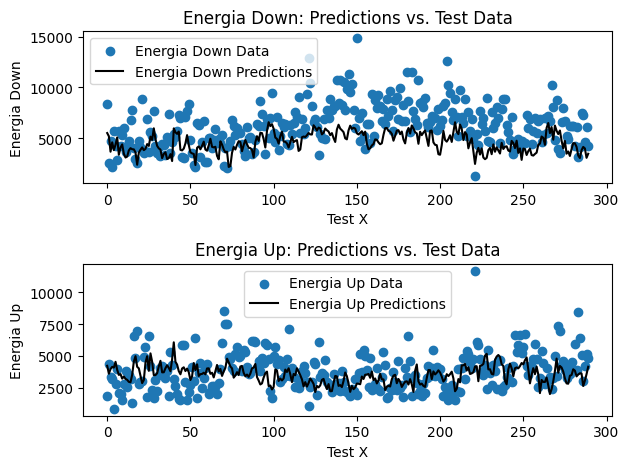

In [80]:
plot_pred_vs_test(np.arange(len(test_dataset_Y_mean)), test_dataset_Y_mean.squeeze(), predictions_mean)

The root mean squared erros in Energia down is 2512.7446778449357
The root mean squared erros in Energia up is 1500.2654847903477
The root mean squared erros in both is 2069.3818329263536


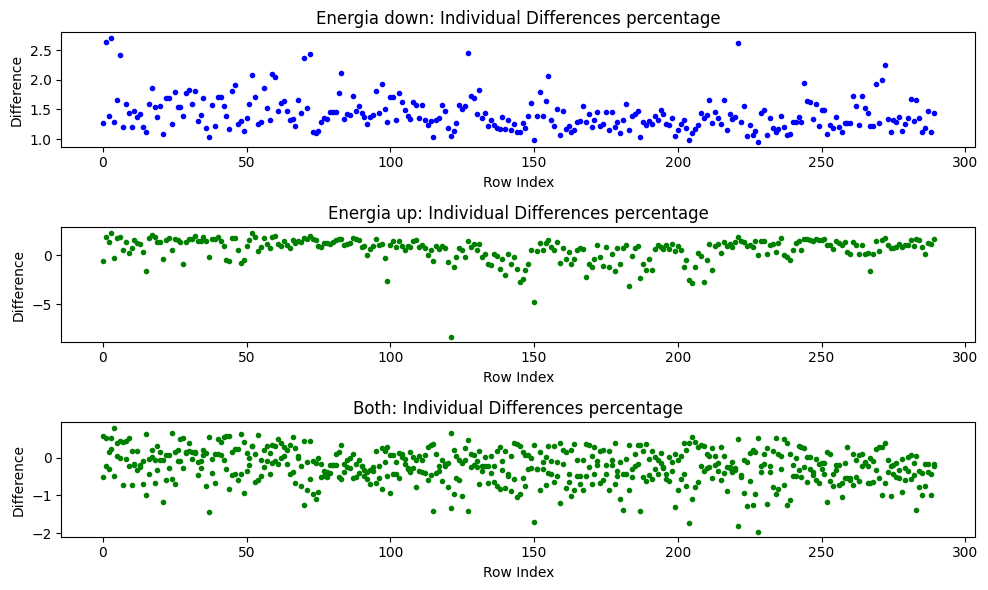

In [81]:
plot_percentage_diffs(predictions_mean, test_dataset_Y_mean)

In [82]:

end_ind = test_dataset[(test_dataset["Day-ahead Forecast Wind"]==test_dataset_X[-1][0][0])&(test_dataset["DA Tie Lines Balance"]==test_dataset_X[-1][0][4])].index.item()
start_ind = test_dataset[(test_dataset["Day-ahead Forecast Wind"]==test_dataset_X[0][0][0])&(test_dataset["DA Tie Lines Balance"]==test_dataset_X[0][0][4])].index.item()

In [83]:
test_dataset[start_ind:end_ind]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
Day                                                                       
1165        5012.4      3572.0                 207223.0       64396.100   
1166        5057.3      2237.0                 234199.0       26066.200   
1167        5184.5      2894.4                 227613.0       59379.300   
1168        4711.3      2608.2                 144318.0       71619.000   
1169        6775.3      1306.9                 335886.0       21657.600   
...            ...         ...                      ...             ...   
1449        6175.0      3590.6                 260326.6       44047.200   
1450        6184.0      4506.6                 276738.3       23170.850   
1451        6140.9      3871.1                 312371.2       28340.425   
1452        4219.1      5974.0                 275411.3       32023.675   
1453        6063.8      3892.3                 242401.9       41455.350   

      DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
Day                                                                 
1165             688468.0          669164.1                7700.6   
1166             680176.0          655075.3               16221.0   
1167             604266.0          653291.4              -67134.4   
1168             565718.0          609984.9              -52956.1   
1169             670117.0          749540.7              -87289.5   
...                   ...               ...                   ...   
1449             682907.7          696038.2              -37674.4   
1450             689439.6          695651.0              -40152.2   
1451             685301.2          710741.5              -68005.5   
1452             678244.7          705601.0              -71508.8   
1453             642797.4          666704.0              -65525.3   

      DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
Day                                                                      
1165        212109.0       64757.3               None             None   
1166        249242.3       33108.1               None             None   
1167        243212.6       67796.3               None             None   
1168        163328.6       69934.9               None             None   
1169        355977.5       30426.5               None             None   
...              ...           ...                ...              ...   
1449        279090.4       48380.5        5251.265625    -12181.265625   
1450        288969.2       31886.6        3854.226807     -7282.534668   
1451        327063.8       35924.8        1232.488037     17355.482422   
1452        308870.2       37106.1       -2467.748535      15027.59375   
1453        273442.8       48240.2      -10667.650391     17845.523438   

     dense2 Energia Down dense2 Energia Up conv Energia Down conv Energia Up  
Day                                                                           
1165                None              None              None            None  
1166                None              None              None            None  
1167                None              None              None            None  
1168                None              None              None            None  
1169         3543.971924       2169.174561              None            None  
...                  ...               ...               ...             ...  
1449         3971.140625       2497.075195       3225.794189     3438.579346  
1450         3698.524414       2467.013916       3907.247803     3496.963867  
1451         3819.945068       2249.611816       4487.548828     3946.723145  
1452         3899.268555       2053.588379       4475.773926     3840.161133  
1453         3724.539551       1893.638672        4123.34082     3387.669922  

[289 rows x 15 columns]

In [84]:
# RNN try

from tensorflow.keras.layers import (
    LSTM,
    BatchNormalization,
    Bidirectional,
    Dense,
    Dropout,
    MaxPooling1D,
)

# channels last -> channels sao as dimensoes diff
input_layer_saphe = (time_length, 7)
filters = 128
dropout_value = 0.25
kernel_size = 3
input_layer = Input(input_layer_saphe)
normed = BatchNormalization()(input_layer)


lstm_units = (120, 80)
pool_size = 3


x = BatchNormalization()(normed)
x = LSTM(
    lstm_units[0],
    return_sequences=True,
    dropout=dropout_value,
    recurrent_dropout=dropout_value,
)(x)
x = MaxPooling1D(pool_size=pool_size)(x)
x = BatchNormalization()(x)
x = Bidirectional(
    LSTM(
        lstm_units[1],
        dropout=dropout_value,
        recurrent_dropout=dropout_value,
    )
)(x)
x = BatchNormalization()(x)
x = Dropout(dropout_value)(x)
x = Dense(120, activation="linear")(x)
x = BatchNormalization()(x)
x = Dense(1, activation="linear")(x)

x = Dense(2, activation="linear")(x)
x = tf.reshape(x, (-1, 1, 2))


model_rnn = Model(inputs=input_layer, outputs=x)


In [85]:
model_rnn.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7, 7)]            0         
                                                                 
 batch_normalization_5 (Bat  (None, 7, 7)              28        
 chNormalization)                                                
                                                                 
 batch_normalization_6 (Bat  (None, 7, 7)              28        
 chNormalization)                                                
                                                                 
 lstm (LSTM)                 (None, 7, 120)            61440     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 2, 120)            0         
 g1D)                                                            
                                                           

In [86]:
model_rnn.compile(optimizer='adam',loss=root_mean_squared_error, metrics=root_mean_squared_error)

In [87]:
model_rnn.fit(train_dataset_X, train_dataset_Y, epochs=5)

Epoch 1/5
37/37 [==============================] - 6s 10ms/step - loss: 4151.0181 - root_mean_squared_error: 4157.7983
Epoch 2/5
37/37 [==============================] - 0s 10ms/step - loss: 4149.6226 - root_mean_squared_error: 4152.6826
Epoch 3/5
37/37 [==============================] - 0s 11ms/step - loss: 4148.4258 - root_mean_squared_error: 4148.3018
Epoch 4/5
37/37 [==============================] - 0s 10ms/step - loss: 4144.6167 - root_mean_squared_error: 4148.2993
Epoch 5/5
37/37 [==============================] - 0s 11ms/step - loss: 4143.8496 - root_mean_squared_error: 4147.6494


In [88]:
uri = "model_rnn_day.keras"
model_rnn.save(uri)


In [89]:
predictions = model_rnn.predict(test_dataset_X)

10/10 [==============================] - 0s 3ms/step


In [90]:
predictions_mean = moving_mean_predictions(predictions)
test_dataset_Y_mean = moving_mean_predictions(test_dataset_Y)

/tmp/ipykernel_94750/2155408381.py:17: RuntimeWarning: Mean of empty slice
  moving_mean = np.nanmean(flatten_preds, axis=0)


In [91]:
test_dataset["rnn Energia Down"] = None
test_dataset["rnn Energia Up"] = None

test_dataset.loc[test_index, "rnn Energia Down"] = predictions_mean[:,0]
test_dataset.loc[test_index, "rnn Energia Up"] = predictions_mean[:,1]


In [92]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
Day                                                                       
1           3208.1      3884.2                  83498.0       18200.400   
2           4229.3      2959.8                 192063.0       17533.200   
3           4145.4      1638.5                 104731.0       16052.500   
4           6426.2      1909.4                  76990.0       17527.500   
5           4404.1      3164.6                 126802.0       18725.900   
...            ...         ...                      ...             ...   
1457        7228.5      3053.5                  62953.8       53616.075   
1458        4616.6      4176.3                 201301.9       52068.150   
1459        6075.9      5159.1                 262304.4       30793.750   
1460        4192.2      4867.0                 321437.3       35352.575   
1461        3484.7      8618.4                 220095.8       49667.725   

      DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
Day                                                                 
1                551279.0          482204.4               51667.1   
2                717903.0          608859.8               56969.3   
3                770761.0          638226.1               52212.9   
4                752428.0          682271.6               21331.5   
5                671707.0          596638.5               35874.6   
...                   ...               ...                   ...   
1457             584216.1          566693.5                2401.5   
1458             588861.7          594076.6              -18313.3   
1459             596548.0          577704.6              -10737.5   
1460             584977.7          576596.5              -12904.7   
1461             481006.5          439263.1               37075.8   

      DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
Day                                                                      
1            97837.6       19967.0               None             None   
2           201687.1       18444.8               None             None   
3           112056.9       16760.5               None             None   
4            82172.4       17801.4               None             None   
5           145371.3       18896.8               None             None   
...              ...           ...                ...              ...   
1457         77798.2       62140.5       -5749.852051     11038.884766   
1458        223593.1       59960.3        3529.900391      5128.436523   
1459        279898.9       42265.3        5314.766113    -29489.410156   
1460        314735.0       37485.8        3018.013428    -24735.019531   
1461        187213.9       53107.4               None             None   

     dense2 Energia Down dense2 Energia Up conv Energia Down conv Energia Up  \
Day                                                                            
1                   None              None              None            None   
2                   None              None              None            None   
3                   None              None              None            None   
4                   None              None              None            None   
5                   None              None              None            None   
...                  ...               ...               ...             ...   
1457         2984.287598       1963.096924       4119.030273     2628.769531   
1458         3539.932617        2203.24585       3969.769775     3044.156738   
1459         3589.358643       2408.167236       3040.736572     3563.818359   
1460                None              None        3443.71582     4148.777832   
1461                None              None              None            None   

     rnn Energia Down rnn Energia Up  
Day                                   
1                None           None  
2          

(290,)
(290, 2)


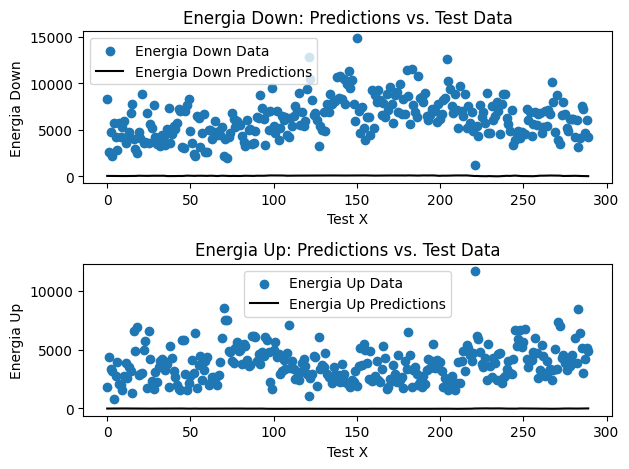

In [93]:
plot_pred_vs_test(np.arange(len(test_dataset_Y_mean)), test_dataset_Y_mean.squeeze(), predictions_mean)

The root mean squared erros in Energia down is 6548.281061570376
The root mean squared erros in Energia up is 4076.0243806181793
The root mean squared erros in both is 5454.079189593558


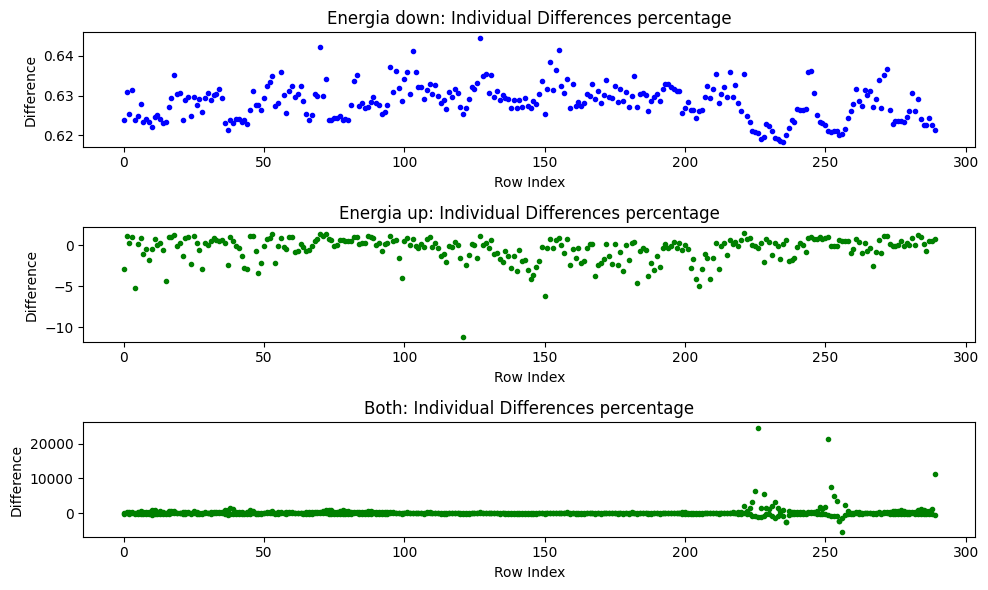

In [94]:
plot_percentage_diffs(predictions_mean, test_dataset_Y_mean)

In [95]:
# Simple CNN
import tensorflow as tf
from keras.models import Model

from tensorflow.keras.layers import (
    LSTM,
    BatchNormalization,
    Bidirectional,
    Dense,
    Dropout,
    MaxPooling1D,Conv1D,Conv2D
)
from tensorflow.keras.layers import Input
pool_size = 3

time_length=7
# channels last -> channels sao as dimensoes diff
input_layer_saphe = (time_length, 7)
filters = 128
dropout_value = 0.25
kernel_size = 3
input_layer = Input(input_layer_saphe)
normed = BatchNormalization()(input_layer)

x = Conv1D(filters=filters, kernel_size=kernel_size, activation='linear')(normed)
x = BatchNormalization()(x)

x = MaxPooling1D(pool_size=pool_size)(x)
x = Conv1D(3, kernel_size=kernel_size, data_format="channels_first")(x)
x = Conv1D(2, kernel_size=kernel_size,data_format="channels_last")(x)

# x = Dense(100, activation="linear")(x)
# x = Dense(24 * 2, activation="linear")(x)
# x = tf.reshape(x, (-1, 24, 2))


model_cnn = Model(inputs=input_layer, outputs=x)


In [96]:
model_cnn.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 7, 7)]            0         
                                                                 
 batch_normalization_10 (Ba  (None, 7, 7)              28        
 tchNormalization)                                               
                                                                 
 conv1d_4 (Conv1D)           (None, 5, 128)            2816      
                                                                 
 batch_normalization_11 (Ba  (None, 5, 128)            512       
 tchNormalization)                                               
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 1, 128)            0         
 g1D)                                                            
                                                           

In [97]:
model_cnn.compile(optimizer='adam',loss=root_mean_squared_error, metrics=root_mean_squared_error)
model_cnn.fit(train_dataset_X, train_dataset_Y, epochs=10)
uri = "model_cnn_day.keras"
model_cnn.save(uri)


Epoch 1/10
37/37 [==============================] - 1s 3ms/step - loss: 4148.7783 - root_mean_squared_error: 4150.3281
Epoch 2/10
37/37 [==============================] - 0s 3ms/step - loss: 4134.9243 - root_mean_squared_error: 4127.4712
Epoch 3/10
37/37 [==============================] - 0s 3ms/step - loss: 4106.9438 - root_mean_squared_error: 4102.1187
Epoch 4/10
37/37 [==============================] - 0s 3ms/step - loss: 4058.5745 - root_mean_squared_error: 4053.7900
Epoch 5/10
37/37 [==============================] - 0s 3ms/step - loss: 3984.2344 - root_mean_squared_error: 3979.2581
Epoch 6/10
37/37 [==============================] - 0s 3ms/step - loss: 3880.5864 - root_mean_squared_error: 3877.2458
Epoch 7/10
37/37 [==============================] - 0s 3ms/step - loss: 3742.7129 - root_mean_squared_error: 3738.3804
Epoch 8/10
37/37 [==============================] - 0s 3ms/step - loss: 3571.6382 - root_mean_squared_error: 3566.3242
Epoch 9/10
37/37 [==============================

In [98]:
predictions = model_rnn.predict(test_dataset_X)
predictions_mean = moving_mean_predictions(predictions)
test_dataset_Y_mean = moving_mean_predictions(test_dataset_Y)

10/10 [==============================] - 0s 3ms/step


/tmp/ipykernel_94750/2155408381.py:17: RuntimeWarning: Mean of empty slice
  moving_mean = np.nanmean(flatten_preds, axis=0)


In [99]:
test_dataset["cnn Energia Down"] = None
test_dataset["cnn Energia Up"] = None

test_dataset.loc[test_index, "cnn Energia Down"] = predictions_mean[:,0]
test_dataset.loc[test_index, "cnn Energia Up"] = predictions_mean[:,1]


(290,)
(290, 2)


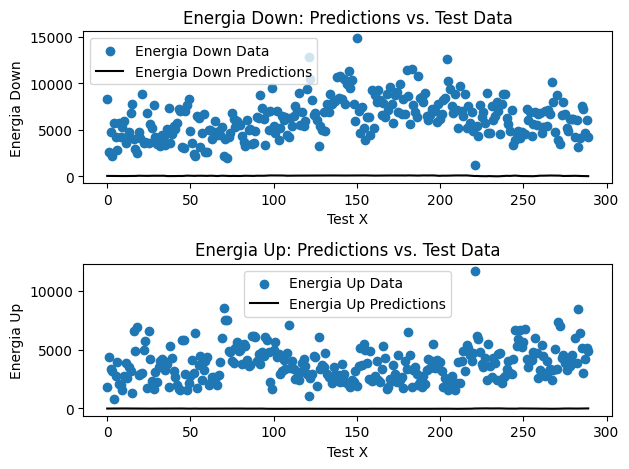

In [100]:
plot_pred_vs_test(np.arange(len(test_dataset_Y_mean)), test_dataset_Y_mean.squeeze(), predictions_mean)

The root mean squared erros in Energia down is 6548.281061570376
The root mean squared erros in Energia up is 4076.0243806181793
The root mean squared erros in both is 5454.079189593558


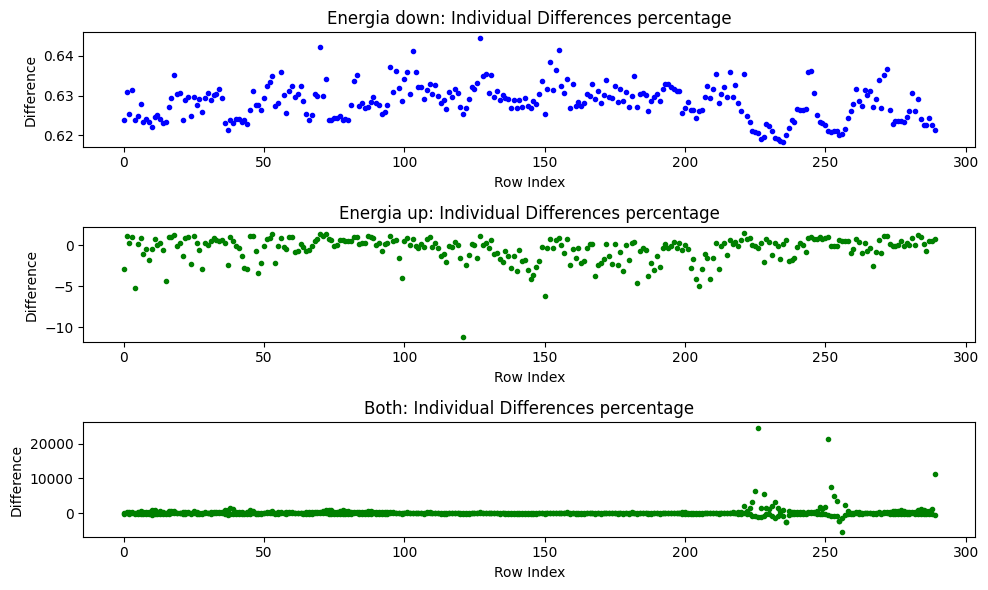

In [101]:
plot_percentage_diffs(predictions_mean, test_dataset_Y_mean)

In [102]:
down_cols = [f for f in test_dataset.columns if "Energia Down" in f]
up_cols = [f for f in test_dataset.columns if "Energia Up" in f]

down_dataset = test_dataset[down_cols].dropna().copy()
up_dataset = test_dataset[up_cols].dropna().copy()

<Axes: xlabel='Day'>

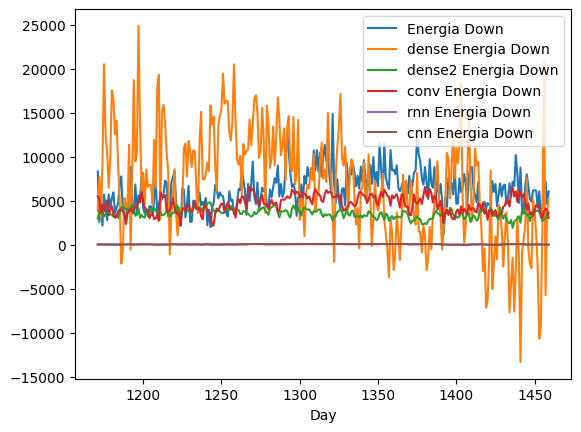

In [103]:
down_dataset.plot()

<Axes: xlabel='Day'>

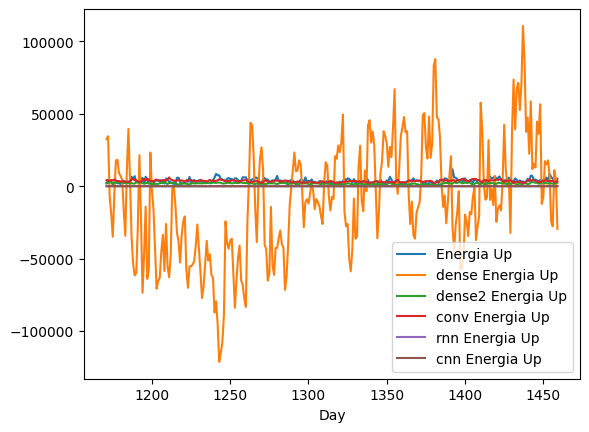

In [104]:
up_dataset.dropna().plot()

In [105]:

cols_use = [f for f in up_dataset.columns if f != "Energia Up"]

for i in cols_use:
    new_name = f"{i} error"
    up_dataset[new_name] = ((up_dataset["Energia Up"]+1.99) - (up_dataset[i]+1.99))/(1.99+up_dataset["Energia Up"])
    
cols_use = [f for f in down_dataset.columns if f != "Energia Down"]

for i in cols_use:
    new_name = f"{i} error"
    down_dataset[new_name] = ((down_dataset["Energia Down"]+1.99) - (down_dataset[i]+1.99))/(1.99+down_dataset["Energia Down"])

In [106]:
up_cols_erro = [f for f in up_dataset.columns if "erro" in f]
down_cols_erro = [f for f in down_dataset.columns if "erro" in f]


<Axes: xlabel='Day'>

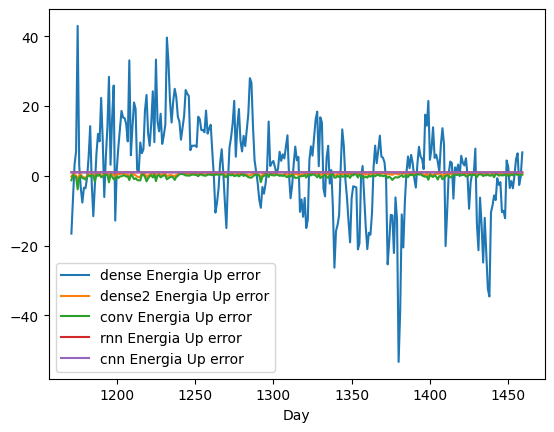

In [107]:
up_dataset[up_cols_erro].plot()

<Axes: xlabel='Day'>

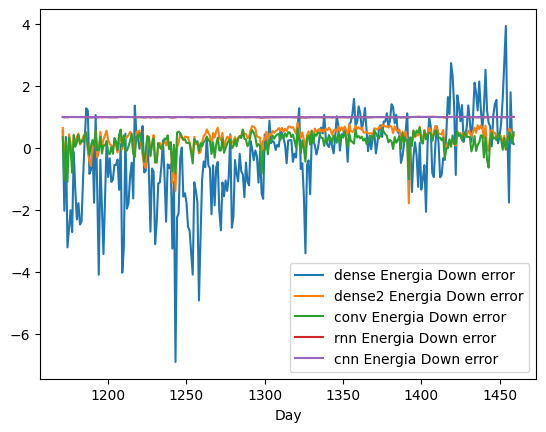

In [108]:
down_dataset[down_cols_erro].plot()

<Axes: xlabel='Day'>

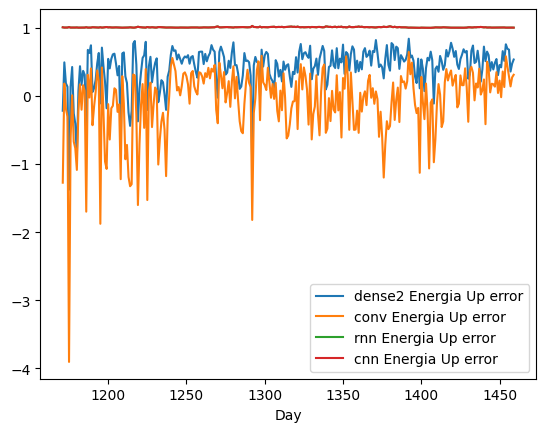

In [109]:
up_cols_erro = [f for f in up_cols_erro if "dense E" not in f]
up_dataset[up_cols_erro].plot()

<Axes: xlabel='Day'>

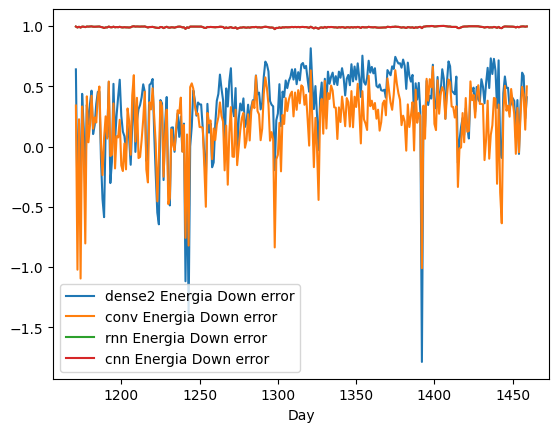

In [110]:
down_cols_erro = [f for f in down_cols_erro if "dense E" not in f]

down_dataset[down_cols_erro].plot()